In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('comments.csv')

In [3]:
df.head(5)

,Unnamed: 0,body,sentiment,score
0,0,Yeah but what the above commenter is saying is...,0.5719,2
1,1,Any comparison of efficiency between solar and...,-0.9877,2
2,2,I'm honestly waiting for climate change and th...,-0.1143,1
3,3,Not just Sacramento. It's actually happening a...,0.0000,4
4,4,I think climate change tends to get some peopl...,0.6634,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10000 non-null  int64  
 1   body        10000 non-null  object 
 2   sentiment   9803 non-null   float64
 3   score       10000 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 312.6+ KB


In [5]:
df = df.dropna()

In [6]:
df = df.drop(columns=['Unnamed: 0'])

In [7]:
df.describe()

,sentiment,score
count,9803.000000,9803.000000
mean,-0.039246,12.056717
std,0.636755,93.988481
min,-0.999700,-229.000000
25%,-0.636900,1.000000
50%,0.000000,2.000000
75%,0.542300,5.000000
max,0.999800,6439.000000


In [8]:
print(df["score"].nunique())
print(df["sentiment"].nunique())

284
4372


In [9]:
df['score'].max(), df['score'].min()

(6439, -229)

In [10]:
df['sentiment'].max(), df['sentiment'].min()

(0.9998, -0.9997)

# Pre-proccesing

In [11]:
import re
from html import unescape
import string

In [12]:
def cleaning_text(text):
    # Convert HTML entities to their corresponding characters
    text = unescape(text)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove square brackets and their contents
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove digits and words with digits
    text = re.sub(r'\w*\d\w*', '', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Replace multiple whitespace with a single space
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove punctuation and special characters
    text = re.sub(r'[{}]'.format(re.escape(string.punctuation)), '', text)
    
    # Remove digits and words with digits
    text = re.sub(r'\b\w*\d\w*\b', '', text)  
    
    return text

In [13]:
# Apply preprocessing to the 'text' column
df['cleaned_text'] = df['body'].apply(cleaning_text)

In [14]:
from nltk.tokenize import word_tokenize
from nltk.stem import  WordNetLemmatizer
from nltk.corpus import stopwords

In [15]:
def tokenize_and_process(text):
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into a single string
    processed_text = ' '.join(tokens)
    
    return processed_text

In [16]:
# Apply preprocessing to the 'text' column
df['processed_text'] = df['cleaned_text'].apply(tokenize_and_process)

In [17]:
# Define thresholds
threshold = 0

# Function to classify sentiment
def classify_sentiment(value):
    if value >= threshold:
        return 'Positive',1
    elif value < threshold:
        return 'Negative',0

In [18]:
df[['sentiment_class', 'sentiment_label']] = df['sentiment'].apply(classify_sentiment).apply(pd.Series)

In [19]:
df['sentiment_label'].value_counts()

sentiment_label
1    5011
0    4792
Name: count, dtype: int64

In [20]:
positive_comments = df[df['sentiment_label'] == 1]
negative_comments = df[df['sentiment_label'] == 0]

In [21]:
highest_positive = positive_comments.loc[positive_comments['score'].idxmax()]
lowest_positive = positive_comments.loc[positive_comments['score'].idxmin()]

highest_negative = negative_comments.loc[negative_comments['score'].idxmax()]
lowest_negative = negative_comments.loc[negative_comments['score'].idxmin()]

print("Highest Positive Comment:")
print("Score:", highest_positive['score'])
print("Comment:", highest_positive['body'])
print("\nLowest Positive Comment:")
print("Score:", lowest_positive['score'])
print("Comment:", lowest_positive['body'])

print("\nHighest Negative Comment:")
print("Score:", highest_negative['score'])
print("Comment:", highest_negative['body'])
print("\nLowest Negative Comment:")
print("Score:", lowest_negative['score'])
print("Comment:", lowest_negative['body'])

Highest Positive Comment:
Score: 1858
Comment: Except they did and do.  "Unprecedented droughts" and
"Increased cyclic extremes of weather" are two common things in climate change caused by global warming.  There isn't a way to to know for sure which rivers were going to be hit first,   but all will be hit sooner or later.  Welcome to the dry age.

Lowest Positive Comment:
Score: -129
Comment: Is it smart? Yeah, sure. It is always interesting how such micro-states find way to make at least some profit. But let's be honest, most of those micro-states, especially in Oceania, shouldn't exist at all as independent countries. They would make much better being authonomous regions of bigger states out there. 11k mega poor people living on thin coral islands that can completely disappeared in the coming years because of climate change and there is no perspectives for economy development. What can go wrong?

Highest Negative Comment:
Score: 6439
Comment: "Estimates of up to a million or more bi

In [22]:
from rake_nltk import Rake

rake = Rake()
def extract_keywords(text):
    if isinstance(text, str):
        rake.extract_keywords_from_text(text)
        keywords = rake.get_ranked_phrases()
        return keywords
    else:
        return []

In [23]:
df['keywords'] = df['cleaned_text'].apply(extract_keywords)

# Analysis

In [24]:
import matplotlib.pyplot as plt
from plotly import graph_objs as go
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

In [25]:
# Count the number of each sentiment class
positive_count = positive_comments.shape[0]
negative_count = negative_comments.shape[0]

labels = ['Positive', 'Negative']
counts = [positive_count, negative_count]
sorted_indices = sorted(range(len(counts)),
                key=lambda i: counts[i], reverse=True)
sorted_labels = [labels[i] for i in sorted_indices]
sorted_counts = [counts[i] for i in sorted_indices]

# Create the bar chart
fig = go.Figure(data=[go.Bar(
    x=sorted_labels,
    y=sorted_counts,
    marker_color=['lightgreen', 'lightcoral'],
    text=[f'{count}' for count in sorted_counts],  
    textposition='inside',  
    textfont=dict(size=12, color='black')  
)])

# Customize the layout
fig.update_layout(
    title='Count of Sentiment',
    xaxis_title='Sentiment',
    yaxis_title='Count',
    xaxis=dict(tickvals=[0, 1], ticktext=['Positive', 'Negative']),
    yaxis=dict(title='Count')
)

# Show the plot
fig.show()


In [26]:
temp = df.groupby('sentiment_class').count()['body'].reset_index().sort_values(by='body',ascending=False)

fig = go.Figure(go.Funnelarea(
    text =temp.sentiment_class,
    values = temp.body,
    title = {"position": "top center", "text": "Sentiment Distribution"}
    ))
fig.show()

In [27]:
# Calculate the length of each comment
df['comment_length'] = df['body'].apply(len)

# Group by sentiment class and calculate the average length
average_length = df.groupby('sentiment_label')['comment_length'].mean().reset_index()

# Prepare data for the plot
sentiment_classes = average_length['sentiment_label']
average_lengths = average_length['comment_length']

# Create the bar chart
fig = go.Figure(data=[go.Bar(
    x=sentiment_classes,
    y=average_lengths,
    marker_color=['lightgreen', 'lightcoral'],
    text=average_lengths,  
    texttemplate='%{text:.2f}',  
    textposition='inside',  
    textfont=dict(size=12, color='black')  
)])

# Customize the layout
fig.update_layout(
    title='Average Comment Length by Sentiment Class',
    xaxis_title='Sentiment Class',
    yaxis_title='Average Comment Length',
    xaxis=dict(tickvals=[0, 1], ticktext=['Negative', 'Positive']),
    yaxis=dict(title='Average Comment Length'),
    uniformtext_minsize=8,  
    uniformtext_mode='hide'  
)

# Show the plot
fig.show()

In [28]:
# Define the threshold
threshold = 0

# Filter comments based on the threshold using predefined dataframes
positive_score_count = positive_comments[positive_comments['score'] > threshold].shape[0]
negative_score_count = negative_comments[negative_comments['score'] > threshold].shape[0]

# Prepare data for the plot
labels = ['Positive Score', 'Negative Score']
counts = [positive_score_count, negative_score_count]

# Create the bar chart
fig1 = go.Figure(data=[go.Bar(
    x=labels,
    y=counts,
    marker_color=['lightgreen', 'lightcoral'],
    text=[f'{count}' for count in counts],  
    textposition='inside',  
    textfont=dict(size=12, color='black')  
)])

# Customize the layout
fig1.update_layout(
    title='Number of Comments by Sentiment and Score',
    xaxis_title='Category',
    yaxis_title='Number of Comments',
    xaxis=dict(tickvals=[0, 1], ticktext=['Positive Score', 'Negative Score']),
    yaxis=dict(title='Number of Comments'),
    uniformtext_minsize=8,  
    uniformtext_mode='hide'  
)

# Show the plot
fig1.show()


In [29]:
# Calculate average score for positive and negative comments
average_positive_score = positive_comments['score'].mean()
average_negative_score = negative_comments['score'].mean()
average_scores = [average_positive_score, average_negative_score]

# Create the bar chart
fig = go.Figure(data=[go.Bar(
    x=['Positive', 'Negative'],
    y=[average_positive_score, average_negative_score],
    marker_color=['lightgreen', 'lightcoral'],
    text=[f'{score:.0f}' for score in average_scores],  
    textposition='inside',  
    textfont=dict(size=12, color='black') 
)])

# Customize the layout
fig.update_layout(
    title='Average Score for Positive and Negative Comments',
    xaxis_title='Sentiment',
    yaxis_title='Average Score',
    xaxis=dict(tickvals=[0, 1], ticktext=['Positive', 'Negative']),
    yaxis=dict(title='Average Score')
)

# Show the plot
fig.show()

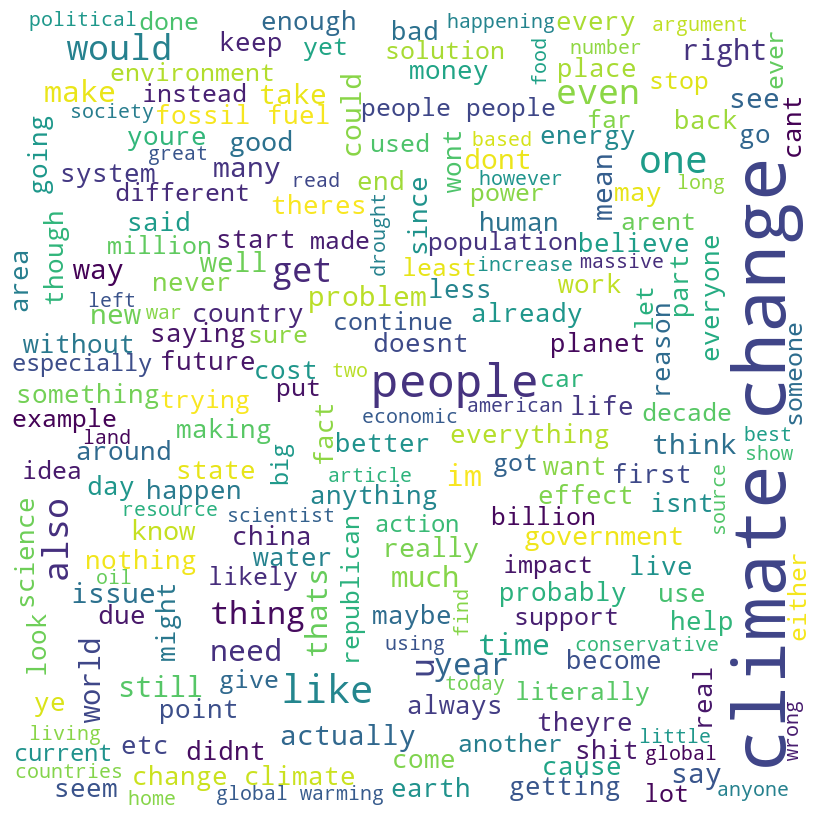

In [30]:
all_keywords = ' '.join([' '.join(keywords) for keywords in
                                df['keywords'] if isinstance(keywords, list)])

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(),
                min_font_size = 10).generate(all_keywords)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [31]:
import itertools

all_keywords = list(itertools.chain.from_iterable(df['keywords']))

keyword_counts = Counter(all_keywords)

most_common_keywords = keyword_counts.most_common(10)
words, counts = zip(*most_common_keywords)

top_keywords_df = pd.DataFrame({
    'Keyword': words,
    'Frequency': counts
})

fig = go.Figure(data=[go.Bar(
    x=top_keywords_df['Keyword'],
    y=top_keywords_df['Frequency'],
    marker_color='lightblue',
    text=top_keywords_df['Frequency'],   
    textposition='inside',  
    textfont=dict(size=12, color='black')   
)])

fig.update_layout(
    title='Top 10 Most Frequent Keywords',
    xaxis_title='Keywords',
    yaxis_title='Frequency',
    xaxis_tickangle=-45  
)

# Show the plot
fig.show()

In [32]:
df['temp_list'] = df['processed_text'].apply(lambda x: str(x).split())
top = Counter([item for sublist in df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words', 'count']

# Create the bar chart
fig = go.Figure(data=[go.Bar(
    x=temp['Common_words'],
    y=temp['count'],
    marker_color='skyblue',  
    text=temp['count'],   
    textposition='outside',  
    textfont=dict(size=11, color='black')  
)])

# Customize the layout
fig.update_layout(
    title='Top 10 Most Common Words',
    xaxis_title='Words',
    yaxis_title='Count',
    xaxis_tickangle=-45,  
    yaxis=dict(title='Count'),
)

# Show the plot
fig.show()


In [33]:
Positive_sent = df[df['sentiment_class']=='Positive']

# Calculate the most common positive words
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10))
temp_positive.columns = ['Common_words', 'count']

# Create the bar chart
fig = go.Figure(data=[go.Bar(
    x=temp_positive['Common_words'],
    y=temp_positive['count'],
    marker_color='lightgreen',
    text=temp_positive['count'],  # Add text labels to the bars
    textposition='outside',  # Position text outside the bars
    textfont=dict(size=11, color='black')  # Set text font size and color
)])

# Customize the layout
fig.update_layout(
    title='Most Common Positive Words',
    xaxis_title='Words',
    yaxis_title='Count',
    xaxis=dict(tickangle=-45),  # Tilt x-axis labels for better readability
    yaxis=dict(title='Count'),
)

# Show the plot
fig.show()


In [34]:
Negative_sent = df[df['sentiment_class']=='Negative']

# Calculate the most common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(10))
temp_negative.columns = ['Common_words', 'count']

# Create the bar chart
fig = go.Figure(data=[go.Bar(
    x=temp_negative['Common_words'],
    y=temp_negative['count'],
    marker_color='lightcoral',
    text=temp_negative['count'], 
    textposition='outside'  
)])

# Customize the layout
fig.update_layout(
    title='Most Common Negative Words',
    xaxis_title='Words',
    yaxis_title='Count',
    xaxis=dict(tickangle=-45),  
    yaxis=dict(title='Count'),
)

# Show the plot
fig.show()


# MODEL

## ML

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, VotingClassifier
import joblib
import numpy as np

c:\Users\2021\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



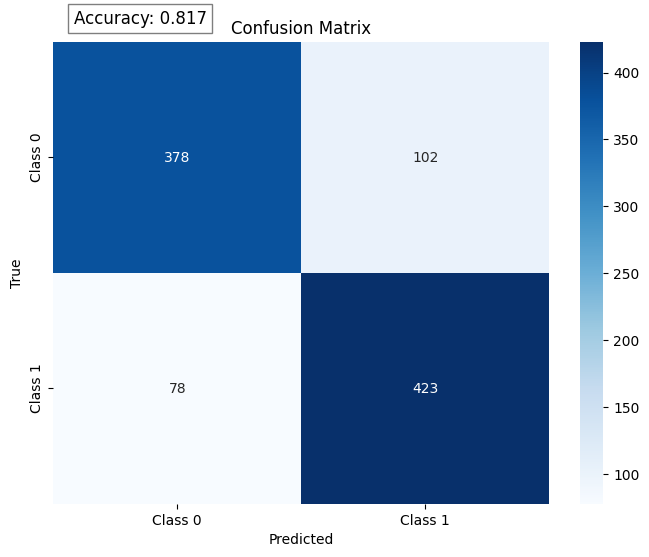

In [36]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'], df['sentiment_label'], 
    stratify=df['sentiment_label'], random_state=25
    , test_size=0.1)

# Create the feature union of TF-IDF
feature_union = FeatureUnion([
    ('tfidf', TfidfVectorizer(
        max_features=5000,      
        sublinear_tf=False,      
        max_df=0.95,            
        min_df=1
    )),  # TF-IDF
])

# pipeline for feature extractionv and classification
pipeline = ImbPipeline([
    ('features', feature_union),
    ('chi2', SelectKBest(chi2, k=800)),  # Feature selection
    ('voting', VotingClassifier(  # Ensemble model
        estimators=[
            ('lr',LogisticRegression(C=10.0)),
            ('ada', AdaBoostClassifier(n_estimators=160)),  
        ],
        voting='soft' 
    ))
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Save the trained model to a file
joblib.dump(pipeline, 'sentiment_analysis.pkl')

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Add accuracy text to the plot
plt.text(x=0.35, y=-0.1, s=f'Accuracy: {accuracy:.3f}', 
        ha='center', va='center', fontsize=12, color='black', 
        bbox=dict(facecolor='white', alpha=0.5))

plt.show()

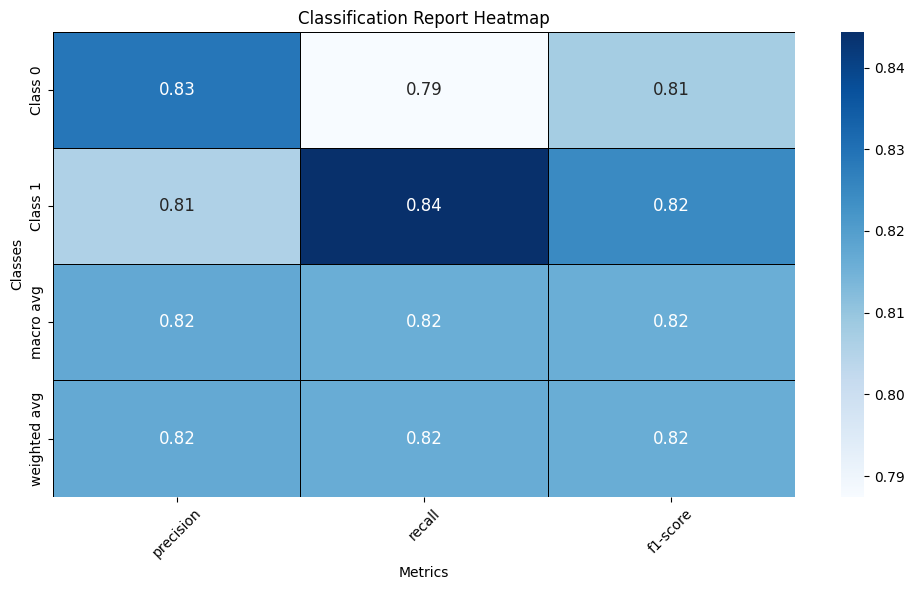

In [37]:
# Generate classification report
report = classification_report(y_test, y_pred, 
                            target_names=['Class 0', 'Class 1'], 
                            output_dict=True)
# Extract relevant metrics into a DataFrame
report_df = pd.DataFrame(report).transpose()

report_df = report_df.loc[
    ['Class 0', 'Class 1', 'macro avg', 'weighted avg'], 
    ['precision', 'recall', 'f1-score']
                        ]
# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df, annot=True, fmt='.2f', 
            cmap='Blues', cbar=True, 
            annot_kws={"size": 12}, 
            linewidths=.5, linecolor='black')

plt.title('Classification Report Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [38]:
# Get the TF-IDF Vectorizer from the pipeline
feature_union = pipeline.named_steps['features']
tfidf_vectorizer = None
for name, transformer in feature_union.transformer_list:
    if name == 'tfidf':
        tfidf_vectorizer = transformer
        break

if tfidf_vectorizer is None:
    raise ValueError("TF-IDF vectorizer not found in FeatureUnion.")

# Get the feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get SelectKBest from the pipeline
select_k_best = pipeline.named_steps['chi2']

# Get the top features
top_features_indices = select_k_best.get_support(indices=True)

# Extract the names of the top features
top_feature_names = [feature_names[i] for i in top_features_indices]

# Extract the weights from Logistic Regression
logistic_regression = pipeline.named_steps['voting'].named_estimators_['lr']
coefficients = logistic_regression.coef_[0]

# Sort the words based on their weights
top_indices = np.argsort(coefficients)[::-1]

# Classify the words based on their weights
top_features = [top_feature_names[i] for i in top_indices]
top_weights = [coefficients[i] for i in top_indices]

# Get the top 3 positive and negative words
positive_words = [(word, weight) for word, weight in zip(top_features, top_weights) if weight > 0]
negative_words = [(word, weight) for word, weight in zip(top_features, top_weights) if weight < 0]

# Sort the words based on their weights
positive_words = sorted(positive_words, key=lambda x: x[1], reverse=True)[1:4]
negative_words = sorted(negative_words, key=lambda x: x[1])[1:4]

# Display the top 3 positive and negative words
print("Top 3 Positive Words:")
for word, weight in positive_words:
    print(f"Word: {word}, Weight: {weight}")

print("\nTop 3 Negative Words:")
for word, weight in negative_words:
    print(f"Word: {word}, Weight: {weight}")


Top 3 Positive Words:
Word: valuable, Weight: 8.02798308220791
Word: super, Weight: 6.835926569376252
Word: better, Weight: 6.626474609722449

Top 3 Negative Words:
Word: crisis, Weight: -9.897051692148542
Word: worst, Weight: -8.698519488754657
Word: worse, Weight: -8.54609969344


In [39]:
# Load the saved model
pipeline = joblib.load('sentiment_analysis.pkl')

In [40]:
# Example test comments with positive and negative words
test_comments = [
    "The new policy is absolutely fantastic and shows great improvement!",
    "This initiative is fantastic and has made a huge positive difference.",
    "The efforts to address environmental issues are excellent; I am very pleased.",
    "I find the new regulations to be poorly thought out and bad for the environment.",
    "The recent decisions are horrible and have no real impact on climate change.",
    "This approach is ineffective and has been a complete failure in addressing issues."]

In [41]:
# Predict sentiments using the loaded model
predictions = pipeline.predict(test_comments)

# Print the results
for comment, sentiment in zip(test_comments, predictions):
    print(f"Comment: {comment}\nPredicted Sentiment: {sentiment}\n")


Comment: The new policy is absolutely fantastic and shows great improvement!
Predicted Sentiment: 1

Comment: This initiative is fantastic and has made a huge positive difference.
Predicted Sentiment: 1

Comment: The efforts to address environmental issues are excellent; I am very pleased.
Predicted Sentiment: 1

Comment: I find the new regulations to be poorly thought out and bad for the environment.
Predicted Sentiment: 0

Comment: The recent decisions are horrible and have no real impact on climate change.
Predicted Sentiment: 0

Comment: This approach is ineffective and has been a complete failure in addressing issues.
Predicted Sentiment: 0



In [42]:
def analyze_words(comment, tfidf_vectorizer, top_feature_names, coefficients, select_k_best):
    # Transform the comment into TF-IDF representation
    tfidf_matrix = tfidf_vectorizer.transform([comment])
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Get the words present in the comment and their TF-IDF scores
    words_in_comment = tfidf_matrix.toarray()[0]
    word_indices = np.argsort(words_in_comment)[::-1]
    
    # Extract general words with their TF-IDF scores
    general_words = [(feature_names[i], words_in_comment[i]) for i in word_indices if words_in_comment[i] > 0]
    
    # Get the significant words with their weights
    significant_words = []
    for index in word_indices:
        if words_in_comment[index] > 0:
            word = feature_names[index]
            if word in top_feature_names:
                feature_index = top_feature_names.index(word)
                weight = coefficients[feature_index]
                significant_words.append((word, weight))
    
    return general_words, significant_words

In [43]:
# Analyze the impact of words in each comment
for comment, sentiment in zip(test_comments, predictions):
    sentiment_label = "Positive" if sentiment == 1 else "Negative"
    
    print("="*80)
    print(f"Comment: {comment}")
    print(f"Predicted Sentiment: {sentiment_label}")
    print("-"*80)
    
    # Get significant and general words
    general_words, significant_words = analyze_words(comment, tfidf_vectorizer, top_feature_names, coefficients, select_k_best)
    
    # Print significant words
    print("Significant Words and Their Weights:")
    if significant_words:
        for word, weight in significant_words:
            print(f" - {word}: {weight:.4f}")
    else:
        print("  No significant words found.")
    
    # Print general words
    print("\nGeneral Words and Their TF-IDF Scores:")
    if general_words:
        for word, score in general_words:
            print(f" - {word}: {score:.4f}")
    else:
        print("  No general words found.")
    
    print()

Comment: The new policy is absolutely fantastic and shows great improvement!
Predicted Sentiment: Positive
--------------------------------------------------------------------------------
Significant Words and Their Weights:
 - fantastic: 0.5662
 - great: 6.3166

General Words and Their TF-IDF Scores:
 - fantastic: 0.5618
 - improvement: 0.5035
 - absolutely: 0.3670
 - great: 0.3307
 - policy: 0.3237
 - new: 0.2864

Comment: This initiative is fantastic and has made a huge positive difference.
Predicted Sentiment: Positive
--------------------------------------------------------------------------------
Significant Words and Their Weights:
 - fantastic: 0.5662
 - positive: 5.8714
 - difference: 2.7288
 - huge: 1.4485

General Words and Their TF-IDF Scores:
 - fantastic: 0.5236
 - initiative: 0.4941
 - positive: 0.4073
 - difference: 0.3637
 - huge: 0.3246
 - made: 0.2798

Comment: The efforts to address environmental issues are excellent; I am very pleased.
Predicted Sentiment: Positive